# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import all Libraries

In [2]:
from __future__ import print_function
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import accuracy_score
from PIL import Image
from tqdm.notebook  import  tqdm
import random
# Import torch libraries
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
%matplotlib inline

CUDA = torch.cuda.is_available()
print("CUDA :: ", CUDA)
device = torch.device("cuda" if CUDA else "cpu")

CUDA ::  True


# Hyper Parameters

Please edit all necessary paramaters

In [3]:
# Network deatils
hidden=64; kernel_size=3 ; padding=1
p1=0.25 ; p2=0.5

# Dataloader 
BATCH = 4

image_directory = "./drive/My Drive/Datasets/Aerial_small/Training/images/"
gt_directory ="./drive/My Drive/Datasets/Aerial_small/Training/labels/"

val_image_directory = "./drive/My Drive/Datasets/Aerial_small/Validation/images/"
val_gt_directory = "./drive/My Drive/Datasets/Aerial_small/Validation/labels/"

test_label_directory = "./drive/My Drive/Datasets/Aerial_small/Test/labels/"
test_image_directory = "./drive/My Drive/Datasets/Aerial_small/Test/images/"

# Training Save Path
PATH = "./drive/My Drive/Datasets/Models/Building/"
print("Train Path exists : ",os.path.exists(PATH))
PATH += "checkpoint"

# Optimizer
learning_rate = 0.0001

# Train
resume_epoch = 500
num_epochs = 650

# Testing Load Path
TEST_PATH = "./drive/My Drive/Datasets/Models/Assignment_Submission/UNet.tar"

Train Path exists :  True


# Define the U-Net Generator Model

In [4]:
class UNet(nn.Module):
    def __init__(self, hidden=64, kernel_size=(3,3), padding=(2,2),p1=0.25, p2=0.5):
        super(UNet,self).__init__()
        '''
        Initializes the layers for the neral network model. The UNet arch is used. Number of outputs = 3
        
        Arguments:
        hidden  --  Number of channels for the first layer. The no of channels for the consequent layers are a multiple of this number
        kernel_size  --  Filter Size for the Conv layers
        padding  --  Padding for the Conv layers. For SAME conv, padding = (kernel_size - 1)/2
        p1 & p2  --  Dropout Layer probabilities
        
        Return:
        None
        '''
        # 1st Block. Process and Downsample by 2
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=kernel_size, padding=padding)
        self.max1  = nn.MaxPool2d((2,2), 2)
        self.drop1 = nn.Dropout2d(p=p1)
        # 2nd Block. Process and Downsample by 2
        self.conv3 = nn.Conv2d(in_channels=hidden, out_channels=hidden*2, kernel_size=kernel_size, padding=padding)
        self.conv4 = nn.Conv2d(in_channels=hidden*2, out_channels=hidden*2, kernel_size=kernel_size, padding=padding)
        self.max2  = nn.MaxPool2d((2,2), 2)
        self.drop2 = nn.Dropout2d(p=p2)
        # 3rd Block. Process and Downsample by 2
        self.conv5 = nn.Conv2d(in_channels=hidden*2, out_channels=hidden*4, kernel_size=kernel_size, padding=padding)
        self.conv6 = nn.Conv2d(in_channels=hidden*4, out_channels=hidden*4, kernel_size=kernel_size, padding=padding)
        self.max3  = nn.MaxPool2d((2,2), 2)
        self.drop3 = nn.Dropout2d(p=p2)
        # 4th Block. Process and Downsample by 2
        self.conv7 = nn.Conv2d(in_channels=hidden*4, out_channels=hidden*8, kernel_size=kernel_size, padding=padding)
        self.conv8 = nn.Conv2d(in_channels=hidden*8, out_channels=hidden*8, kernel_size=kernel_size, padding=padding)
        self.max4  = nn.MaxPool2d((2,2), 2)
        self.drop4 = nn.Dropout2d(p=p2)
        # 5th Block. Process and increase channels
        self.conv9  = nn.Conv2d(in_channels=hidden*8, out_channels=hidden*16, kernel_size=kernel_size, padding=padding)
        self.conv10 = nn.Conv2d(in_channels=hidden*16, out_channels=hidden*16 , kernel_size=kernel_size, padding=padding)
        # 6th Block. Upsample by 2
        self.deconv1 = nn.ConvTranspose2d(in_channels=hidden*16, out_channels=hidden*8, kernel_size=kernel_size, padding=padding, stride=2)
        self.drop5 = nn.Dropout2d(p=p2)
        self.conv11 = nn.Conv2d(in_channels=hidden*16, out_channels=hidden*8, kernel_size=kernel_size, padding=padding)
        self.conv12 = nn.Conv2d(in_channels=hidden*8, out_channels=hidden*8 , kernel_size=kernel_size, padding=padding)
        # 7th Block. Upsample by 2
        self.deconv2 = nn.ConvTranspose2d(in_channels=hidden*8, out_channels=hidden*4, kernel_size=kernel_size, padding=padding, stride=2)
        self.drop6 = nn.Dropout2d(p=p2)
        self.conv13 = nn.Conv2d(in_channels=hidden*8, out_channels=hidden*4, kernel_size=kernel_size, padding=padding)
        self.conv14 = nn.Conv2d(in_channels=hidden*4, out_channels=hidden*4 , kernel_size=kernel_size, padding=padding)
        # 8th Block. Upsample by 2
        self.deconv3 = nn.ConvTranspose2d(in_channels=hidden*4, out_channels=hidden*2, kernel_size=kernel_size, padding=padding, stride=2)
        self.drop7 = nn.Dropout2d(p=p2)
        self.conv15 = nn.Conv2d(in_channels=hidden*4, out_channels=hidden*2, kernel_size=kernel_size, padding=padding)
        self.conv16 = nn.Conv2d(in_channels=hidden*2, out_channels=hidden*2 , kernel_size=kernel_size, padding=padding)
        # 9th Block. Upsample by 2
        self.deconv4 = nn.ConvTranspose2d(in_channels=hidden*2, out_channels=hidden, kernel_size=kernel_size, padding=padding, stride=2)
        self.drop8 = nn.Dropout2d(p=p2)
        self.conv17 = nn.Conv2d(in_channels=2*hidden, out_channels=hidden, kernel_size=kernel_size, padding=padding)
        self.conv18 = nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=kernel_size, padding=padding)
        # Output Layer with 3 channels for background(green for network, white vizulization), roads(red) and buildings(Blue)
        self.output = nn.Conv2d(in_channels=hidden, out_channels=3, kernel_size=kernel_size, padding=padding)

    def forward(self, x):
        '''
        Forward propogation of the model. The image is first downsampled and the upsampled
        Leaky ReLU is used for the Conv Layer activations
        
        Arguments:
        x  --  Input to the U-Net
        
        Returns
        y  --  Output of the U-Net. Output is the logits and not the softmax probabilities
        '''
        x = nn.LeakyReLU()(self.conv1(x))
        x = nn.LeakyReLU()(self.conv2(x))
        x_2 = self.max1(x)
        x_2 = self.drop1(x_2)

        x_2 = nn.LeakyReLU()(self.conv3(x_2))
        x_2 = nn.LeakyReLU()(self.conv4(x_2))
        x_4 = self.max2(x_2)
        x_4 = self.drop2(x_4)

        x_4 = nn.LeakyReLU()(self.conv5(x_4))
        x_4 = nn.LeakyReLU()(self.conv6(x_4))
        x_8 = self.max3(x_4)
        x_8 = self.drop3(x_8)

        x_8 = nn.LeakyReLU()(self.conv7(x_8))
        x_8 = nn.LeakyReLU()(self.conv8(x_8))
        x_16 = self.max4(x_8)
        x_16 = self.drop4(x_16)

        x_16 = nn.LeakyReLU()(self.conv9(x_16))
        y_16 = nn.LeakyReLU()(self.conv10(x_16))

        y_8 = self.deconv1(y_16, output_size=x_8.size())
        y_8 = torch.cat((y_8, x_8), axis = 1)
        y_8 = nn.LeakyReLU()(self.conv11(y_8))
        y_8 = nn.LeakyReLU()(self.conv12(y_8))

        y_4 = self.deconv2(y_8, output_size=x_4.size())
        y_4 = torch.cat((y_4, x_4), axis=1)
        y_4 = nn.LeakyReLU()(self.conv13(y_4))
        y_4 = nn.LeakyReLU()(self.conv14(y_4))

        y_2 = self.deconv3(y_4, output_size=x_2.size())
        y_2 = torch.cat((y_2, x_2), axis=1)
        y_2 = nn.LeakyReLU()(self.conv15(y_2))
        y_2 = nn.LeakyReLU()(self.conv16(y_2)) 

        y_1 = self.deconv4(y_2, output_size=x.size())
        y_1 = torch.cat((y_1, x), axis=1)
        y_1 = nn.LeakyReLU()(self.conv17(y_1))
        y_1 = nn.LeakyReLU()(self.conv18(y_1))
        y = self.output(y_1)
        return y

# Instatiate the Model, Optimizer and Losses

In [5]:
# Instantiate Model 
segmentation_model = UNet(hidden=hidden, kernel_size=kernel_size, padding=padding).to(device)
# Setup Optimizer
optimizer = torch.optim.Adam(segmentation_model.parameters(), lr = learning_rate)
# Initialize Cross Entropy Loss
criterion_cross = nn.CrossEntropyLoss(weight = torch.tensor([5,1,5], dtype=torch.float).to(device))

# Define Metrics

In [6]:
def dice_index(input, target):
    '''
    Calcualtes the Dice Coefficeint for the 2 specified images

    Arguments:
    pred  --  The predicted image by the neural network
    target  --  The ground truth image/segmented image

    Returns
    coeff.item()  --  The Dice Co-efficient(float) for the predicted image and the ground-truth image 
    '''
    smooth = 1.  # Factor to prevent NaN and maintain smoothness
    pred = nn.Softmax2d()(input)  # Apply Softmax since the network outputs the logits
    target = target.unsqueeze(1)
    target = torch.cat((target==0, target==1, target==2), dim=1).type(torch.float)  # Accomodate all 3 channels
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    return ((2. * intersection + smooth)/(union + smooth)).mean().item()
    
def IoU(input, target):
    '''
    Calcualtes the IoU Coefficeint for the 2 specified images

    Arguments:
    pred  --  The predicted image by the neural network
    target  --  The ground truth image/segmented image

    Returns
    iou.item()  --  The IoU Co-efficient(float) for the predicted image and the ground-truth image
    '''
    smooth = 1.  # Factor to prevent NaN and maintain smoothness
    pred = nn.Softmax2d()(input)  # Apply Softmax since the network outputs the logits
    target = target.unsqueeze(1)
    target = torch.cat((target==0, target==1, target==2), dim=1).type(torch.float)  # Accomodate all 3 channels
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - intersection
    return ((intersection + smooth)/(union + smooth)).mean().item()

# Data Loader class

In [7]:
class SegmentationDatasetLoader(object):
    def __init__(self, img_root_dir, gt_root_dir, train = False):
        '''
        Initialize the Dataloader
        
        Arguments:
        img_root_dir  --  Directory containing the input image files
        gt_root_dir   --  Directory containing the output label files
        train  --  Variable tto differentiate between traning and test/val for data augmentation and transforms
        
        Returns:
        None
        '''
        self.img_root_dir = img_root_dir
        self.gt_root_dir = gt_root_dir
        self.img_list = os.listdir(img_root_dir)
        self.gt_list  = os.listdir(gt_root_dir)
        self.img_list.sort()
        self.gt_list.sort()
        self.train = train

    def __getitem__(self, idx):
        '''
        Based on the input index, reads a filen and the corresponding target and outputs both as processed tensors to the net
        
        Arguments:
        idx  --  The index of the dataframe row to be loaded
        
        Returns:
        img  --  The image tensor of dimension [batch,channels,height,width]
        gt   --  The target for the image loaded in a tensor format [batch,1,height,width]
        '''
        dim = 512
        img = Image.open(os.path.join(self.img_root_dir, self.img_list[idx]))
        gt = cv2.imread(os.path.join(self.gt_root_dir, self.gt_list[idx]))
        # Make the white color as green for one hot encoding
        gt = gt[:,:,[2,1,0]]
        gt[:,:,0] = gt[:,:,0] - gt[:,:,1]
        gt[:,:,2] = gt[:,:,2] - gt[:,:,1]
        gt = Image.fromarray(gt, 'RGB')
        # Resize to a power of 2
        img = TF.resize(img, (dim, dim))
        gt = TF.resize(gt, (dim, dim))
        # Transform only for the training phase
        if self.train:
            if random.random() > 0.5:
                img = TF.vflip(img)
                gt  = TF.vflip(gt)
            if random.random() > 0.5:
                img = TF.hflip(img)
                gt  = TF.hflip(gt)
            if random.random() > 0.5:
                angle = random.randint(0, 45)
                img = TF.rotate(img, angle)
                gt  = TF.rotate(gt,  angle, fill=(0,255,0)) # Fill backgound as green
        # Convert to a tensor from a PIL Image
        img = TF.to_tensor(img)
        gt  = TF.to_tensor(gt) 
        gt  = torch.argmax(gt, dim = 0)
        return img.type(torch.float), gt.type(torch.long)

    def __len__(self):
        '''
        Calculate the number of file/data-points in the directory
        
        Arguments:
        None
        
        Returns:
        Number of files
        '''
        return len(self.img_list)

In [8]:
# Instantiate the Training DataLoader and Data Iterator
segmentation_dataset = SegmentationDatasetLoader(image_directory, gt_directory, train = True)
segmentation_iter = torch.utils.data.DataLoader(segmentation_dataset, batch_size=BATCH, shuffle=True)
# Instantiate the Validation Data Loader and Data Iterator
val_dataset = SegmentationDatasetLoader(val_image_directory, val_gt_directory)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH, shuffle=False)

# Train

In [ ]:
loss_train = []
# Get train and valid iteration size
iterations = len(segmentation_iter)
val_iterations = len(val_iter)
# Resume Check
if resume_epoch == 0:
    print("Starting Training Loop...")
else:
    checkpoint = torch.load(PATH + str(resume_epoch) + '.tar', map_location=device)
    segmentation_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Resuming Training Loop...")
# Training Loop
for epoch in range(resume_epoch, num_epochs):
    loss_epoch = 0
    dice = 0
    dice_val = 0
    iou = 0
    iou_val = 0
    acc_train = 0
    acc_val  = 0 
    segmentation_model.train()
    for img, label in tqdm(segmentation_iter):
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()

        output = segmentation_model(img)
        loss = criterion_cross(output, label)
        loss_epoch += loss.item()

        # Metrics for Training
        acc_train += accuracy_score(label.clone().detach().cpu().numpy().ravel(),  np.argmax(output.clone().detach().cpu().numpy(), axis=1).ravel())
        dice +=  dice_index(output.clone().detach(), label.clone().detach())
        iou  +=  IoU(output.clone().detach(), label.clone().detach())

        # Backprop
        loss.backward()
        optimizer.step()
        
    loss_train.append(loss_epoch)
    print("Epoch : ",epoch + 1, " Loss : ", loss_epoch, " Dice : ", dice/iterations, " IoU : ", iou/iterations, "Accuracy : ", acc_train/iterations)
    if (epoch+1) % 10 == 0:
       torch.save({
          'epoch': epoch+1,
           'model_state_dict': segmentation_model.state_dict(),
           'optimizer_state_dict': optimizer.state_dict(),
           'loss': loss_epoch}, PATH+str(epoch+1)+'.tar')
    
    # Validation
    segmentation_model.eval()
    with torch.no_grad():
        for img_val, label_val in val_iter:
            img_val, label_val = img_val.to(device), label_val.to(device)
            output_val = segmentation_model(img_val)
            # Metrics for the Validation 
            acc_val  += accuracy_score(label_val.clone().detach().cpu().numpy().ravel(),  np.argmax(output_val.clone().detach().cpu().numpy(), axis=1).ravel())
            dice_val +=  dice_index(output_val.clone().detach(), label_val.clone().detach())
            iou_val  +=  IoU(output_val.clone().detach(), label_val.clone().detach())
    print("Validation Dice : ", dice_val/val_iterations, " IoU : ", iou_val/val_iterations, " Acc : ", acc_val/val_iterations)

Resuming Training Loop...



Epoch :  501  Loss :  3.2997907996177673  Dice :  0.8025011053452125  IoU :  0.6755015804217412 Accuracy :  0.8373991159292368
Validation Dice :  0.7683719635009766  IoU :  0.629836916923523  Acc :  0.798851203918457



Epoch :  502  Loss :  3.3155847787857056  Dice :  0.8049478760132422  IoU :  0.678753334742326 Accuracy :  0.8389740723830003
Validation Dice :  0.7612105488777161  IoU :  0.6204438447952271  Acc :  0.7928005218505859



Epoch :  503  Loss :  3.374878317117691  Dice :  0.7981806076489962  IoU :  0.6694990350649908 Accuracy :  0.8345558459942157
Validation Dice :  0.7535588145256042  IoU :  0.6104728698730468  Acc :  0.7905080795288086



Epoch :  504  Loss :  3.346684917807579  Dice :  0.7971019607323867  IoU :  0.6685681159679706 Accuracy :  0.8351658307589017
Validation Dice :  0.7572039842605591  IoU :  0.614911949634552  Acc :  0.7923227310180664



Epoch :  505  Loss :  3.4057821184396744  Dice :  0.8018435423190777  IoU :  0.6751980414757361 Accuracy :  0.8380982325627253
Validation Dice :  0.7463658452033997  IoU :  0.6014275550842285  Acc :  0.7737096786499024



Epoch :  506  Loss :  3.3605330735445023  Dice :  0.7991225306804364  IoU :  0.6712279686560998 Accuracy :  0.8362103975736178
Validation Dice :  0.749066948890686  IoU :  0.6045537233352661  Acc :  0.7812543869018554



Epoch :  507  Loss :  3.29147931933403  Dice :  0.8016102726642902  IoU :  0.6746906042098999 Accuracy :  0.834002421452449
Validation Dice :  0.7376106381416321  IoU :  0.5896627902984619  Acc :  0.7706899642944336



Epoch :  508  Loss :  3.3226882815361023  Dice :  0.8061994176644546  IoU :  0.6814376711845398 Accuracy :  0.8386149039635291
Validation Dice :  0.730616283416748  IoU :  0.580903434753418  Acc :  0.7632322311401367



Epoch :  509  Loss :  3.287591367959976  Dice :  0.8007048276754526  IoU :  0.673337826362023 Accuracy :  0.8373550268319937
Validation Dice :  0.7328449368476868  IoU :  0.583460807800293  Acc :  0.7627622604370117



Epoch :  510  Loss :  3.273110866546631  Dice :  0.8037221523431631  IoU :  0.6763547796469468 Accuracy :  0.8385839462280273
Validation Dice :  0.7411730170249939  IoU :  0.5943726658821106  Acc :  0.7736198425292968



Epoch :  511  Loss :  3.251761734485626  Dice :  0.7975886830916772  IoU :  0.6690120742871211 Accuracy :  0.8344659805297852
Validation Dice :  0.7472991108894348  IoU :  0.6024824023246765  Acc :  0.7725934982299805



Epoch :  512  Loss :  3.325164034962654  Dice :  0.8096963854936453  IoU :  0.6858599140093877 Accuracy :  0.841617070711576
Validation Dice :  0.7363006949424744  IoU :  0.588284170627594  Acc :  0.7711753845214844



Epoch :  513  Loss :  3.347646787762642  Dice :  0.8003074801885165  IoU :  0.6714270527546222 Accuracy :  0.840096693772536
Validation Dice :  0.7485030055046081  IoU :  0.6033526182174682  Acc :  0.778104019165039



Epoch :  514  Loss :  3.283017560839653  Dice :  0.8027177819838891  IoU :  0.6756150447405301 Accuracy :  0.8378853431114783
Validation Dice :  0.744324016571045  IoU :  0.5986818194389343  Acc :  0.7667106628417969



Epoch :  515  Loss :  3.2081134766340256  Dice :  0.8025956520667443  IoU :  0.6759957075119019 Accuracy :  0.8349901346059946
Validation Dice :  0.7604503154754638  IoU :  0.6193955302238464  Acc :  0.7909318923950195



Epoch :  516  Loss :  3.238223671913147  Dice :  0.8067042873455927  IoU :  0.6823023236714877 Accuracy :  0.8402362236609826
Validation Dice :  0.7727262020111084  IoU :  0.6355798363685607  Acc :  0.8018404006958008



Epoch :  517  Loss :  3.3484875708818436  Dice :  0.8036350103525015  IoU :  0.6778308749198914 Accuracy :  0.841174419109638
Validation Dice :  0.755615234375  IoU :  0.6130295157432556  Acc :  0.7911445617675781



Epoch :  518  Loss :  3.2985650300979614  Dice :  0.8028986683258643  IoU :  0.676234061901386 Accuracy :  0.8364640749417819
Validation Dice :  0.7413330197334289  IoU :  0.5950690746307373  Acc :  0.7716714859008789



Epoch :  519  Loss :  3.2652553617954254  Dice :  0.8061769192035382  IoU :  0.6806543010931748 Accuracy :  0.8422334377582257
Validation Dice :  0.7416674256324768  IoU :  0.595710289478302  Acc :  0.7644464492797851



Epoch :  520  Loss :  3.158269003033638  Dice :  0.8051234804666959  IoU :  0.6799058684935937 Accuracy :  0.8382976972139798
Validation Dice :  0.7472439050674439  IoU :  0.6023852229118347  Acc :  0.774808120727539



Epoch :  521  Loss :  3.0576791763305664  Dice :  0.8166809586378244  IoU :  0.6955356827149024 Accuracy :  0.8474757854755108
Validation Dice :  0.7569678544998169  IoU :  0.6148298740386963  Acc :  0.7874256134033203



Epoch :  522  Loss :  3.096330374479294  Dice :  0.8116497626671424  IoU :  0.687687465777764 Accuracy :  0.8468024180485652
Validation Dice :  0.7654629945755005  IoU :  0.6261899471282959  Acc :  0.7923830032348633



Epoch :  523  Loss :  3.1774645298719406  Dice :  0.8148952126502991  IoU :  0.6932771801948547 Accuracy :  0.8478428033682016
Validation Dice :  0.7490410208702087  IoU :  0.6047321081161499  Acc :  0.7754697799682617



Epoch :  524  Loss :  3.1813375800848007  Dice :  0.8077111794398382  IoU :  0.683220230616056 Accuracy :  0.841100105872521
Validation Dice :  0.7490462541580201  IoU :  0.6057343721389771  Acc :  0.7705062866210938



Epoch :  525  Loss :  3.233981043100357  Dice :  0.8177058238249558  IoU :  0.6969125545941867 Accuracy :  0.847742667564979
Validation Dice :  0.7371828556060791  IoU :  0.5897053956985474  Acc :  0.7624679565429687



Epoch :  526  Loss :  3.2050743401050568  Dice :  0.8037742284628061  IoU :  0.6771555267847501 Accuracy :  0.8346494527963492
Validation Dice :  0.7657651543617249  IoU :  0.6267097234725952  Acc :  0.7930112838745117



Epoch :  527  Loss :  3.0712428092956543  Dice :  0.8121260037788978  IoU :  0.6891141946499164 Accuracy :  0.8452226932232196
Validation Dice :  0.7684950113296509  IoU :  0.6297865986824036  Acc :  0.7989290237426758



Epoch :  528  Loss :  3.0281182676553726  Dice :  0.8179488732264593  IoU :  0.697113050864293 Accuracy :  0.8507986068725586
Validation Dice :  0.7597607374191284  IoU :  0.6183460235595704  Acc :  0.7862560272216796



Epoch :  529  Loss :  3.064211890101433  Dice :  0.8195735170291021  IoU :  0.6997063939387982 Accuracy :  0.8517793508676382
Validation Dice :  0.7464992761611938  IoU :  0.60074303150177  Acc :  0.7737491607666016



Epoch :  530  Loss :  3.2152699381113052  Dice :  0.8081048268538255  IoU :  0.6841898881472074 Accuracy :  0.8390037830059345
Validation Dice :  0.7605415344238281  IoU :  0.6202598452568054  Acc :  0.7877777099609375



Epoch :  531  Loss :  3.288967400789261  Dice :  0.8089406627875108  IoU :  0.6840813205792353 Accuracy :  0.8424758177537185
Validation Dice :  0.7545606374740601  IoU :  0.6119713187217712  Acc :  0.7849201202392578



Epoch :  532  Loss :  3.1409016251564026  Dice :  0.8155095485540537  IoU :  0.6937584372667166 Accuracy :  0.8501724096444937
Validation Dice :  0.757093071937561  IoU :  0.6152393221855164  Acc :  0.7857137680053711



Epoch :  533  Loss :  3.182200402021408  Dice :  0.8059403896331787  IoU :  0.6808936779315655 Accuracy :  0.8429308671217698
Validation Dice :  0.7431657671928406  IoU :  0.597257423400879  Acc :  0.771159553527832



Epoch :  534  Loss :  3.1297051161527634  Dice :  0.8155452425663288  IoU :  0.6937285845096295 Accuracy :  0.846942241375263
Validation Dice :  0.7375618934631347  IoU :  0.589329206943512  Acc :  0.7647161483764648



Epoch :  535  Loss :  3.0411363393068314  Dice :  0.8149423049046443  IoU :  0.6930407377389761 Accuracy :  0.8475341796875
Validation Dice :  0.7719365954399109  IoU :  0.6349169254302979  Acc :  0.7994897842407227



Epoch :  536  Loss :  3.144238755106926  Dice :  0.808952313203078  IoU :  0.6854763489503127 Accuracy :  0.838530026949369
Validation Dice :  0.7688381195068359  IoU :  0.6303719997406005  Acc :  0.8022979736328125



Epoch :  537  Loss :  3.1211358159780502  Dice :  0.8112201736523554  IoU :  0.6877028070963346 Accuracy :  0.8455147376427283
Validation Dice :  0.7705471396446228  IoU :  0.6328623414039611  Acc :  0.7964694976806641



Epoch :  538  Loss :  3.0772431790828705  Dice :  0.8169951209655175  IoU :  0.6964443188447219 Accuracy :  0.8488705708430364
Validation Dice :  0.7695456147193909  IoU :  0.6319814682006836  Acc :  0.7959354400634766



Epoch :  539  Loss :  2.9939164519309998  Dice :  0.8212628593811622  IoU :  0.7020268348547128 Accuracy :  0.8530065096341647
Validation Dice :  0.768235731124878  IoU :  0.6296389102935791  Acc :  0.7994928359985352



Epoch :  540  Loss :  3.1413354873657227  Dice :  0.8139249957524813  IoU :  0.6913797396879929 Accuracy :  0.8459581961998572
Validation Dice :  0.7535913228988648  IoU :  0.6101468920707702  Acc :  0.7857715606689453



Epoch :  541  Loss :  3.1453202962875366  Dice :  0.8181572418946487  IoU :  0.6975607459361737 Accuracy :  0.8532432409433218
Validation Dice :  0.7540868639945983  IoU :  0.6109852075576783  Acc :  0.7793725967407227



Epoch :  542  Loss :  3.068427324295044  Dice :  0.82108473777771  IoU :  0.7022821994928213 Accuracy :  0.8512931236853967
Validation Dice :  0.7396769762039185  IoU :  0.5927138924598694  Acc :  0.7644109725952148



Epoch :  543  Loss :  3.0941708385944366  Dice :  0.8146596963589008  IoU :  0.6924075438426092 Accuracy :  0.8454403510460486
Validation Dice :  0.7381920218467712  IoU :  0.5901245713233948  Acc :  0.7691612243652344



Epoch :  544  Loss :  2.9936940521001816  Dice :  0.8205969287798955  IoU :  0.701169110261477 Accuracy :  0.8520196767953726
Validation Dice :  0.7576806783676148  IoU :  0.6157621502876282  Acc :  0.7857463836669922



Epoch :  545  Loss :  3.0927320271730423  Dice :  0.814649338905628  IoU :  0.6930246719947228 Accuracy :  0.8482171572171725
Validation Dice :  0.7716934204101562  IoU :  0.6343714475631714  Acc :  0.7989627838134765



Epoch :  546  Loss :  3.1020591855049133  Dice :  0.8144602179527283  IoU :  0.6924349344693698 Accuracy :  0.84643004490779
Validation Dice :  0.7642806887626648  IoU :  0.6239707708358765  Acc :  0.7978498458862304



Epoch :  547  Loss :  2.9575720578432083  Dice :  0.8245357045760522  IoU :  0.706462575839116 Accuracy :  0.8555009548480694
Validation Dice :  0.7662497758865356  IoU :  0.6273274540901184  Acc :  0.7896627426147461



Epoch :  548  Loss :  3.0686399191617966  Dice :  0.8158707160216111  IoU :  0.6941038966178894 Accuracy :  0.848297485938439
Validation Dice :  0.7497808694839477  IoU :  0.6053872346878052  Acc :  0.7774797439575195



Epoch :  549  Loss :  3.0169595777988434  Dice :  0.8210231891045203  IoU :  0.7019316324820886 Accuracy :  0.8516693848830003
Validation Dice :  0.7244246959686279  IoU :  0.5736488938331604  Acc :  0.7499481201171875



Epoch :  550  Loss :  3.0928439050912857  Dice :  0.8123378478563749  IoU :  0.6890924435395461 Accuracy :  0.84698669727032
Validation Dice :  0.7411149621009827  IoU :  0.5944016695022583  Acc :  0.7682853698730469



Epoch :  551  Loss :  3.1170284748077393  Dice :  0.8151192986048185  IoU :  0.6937081217765808 Accuracy :  0.8483684979952298
Validation Dice :  0.7606819629669189  IoU :  0.6187306761741638  Acc :  0.7969810485839843



Epoch :  552  Loss :  3.0277258306741714  Dice :  0.8191402004315302  IoU :  0.6989925870528588 Accuracy :  0.8533019285935622
Validation Dice :  0.7613896727561951  IoU :  0.6207929491996765  Acc :  0.7884767532348633



Epoch :  553  Loss :  3.012588307261467  Dice :  0.8178986448508042  IoU :  0.6964525901354276 Accuracy :  0.8506765365600586
Validation Dice :  0.759291696548462  IoU :  0.6175548434257507  Acc :  0.7865724563598633



Epoch :  554  Loss :  3.0755708813667297  Dice :  0.8175440934988168  IoU :  0.6971492354686444 Accuracy :  0.8466053009033203
Validation Dice :  0.7684582471847534  IoU :  0.6304229378700257  Acc :  0.788458251953125



Epoch :  555  Loss :  3.1724729239940643  Dice :  0.8131226897239685  IoU :  0.6899362298158499 Accuracy :  0.8455462822547326
Validation Dice :  0.744328248500824  IoU :  0.5987295746803284  Acc :  0.7714052200317383



Epoch :  556  Loss :  3.0136111229658127  Dice :  0.8146220858280475  IoU :  0.693176975617042 Accuracy :  0.8475607358492337
Validation Dice :  0.7636587023735046  IoU :  0.6238091111183166  Acc :  0.7889127731323242



Epoch :  557  Loss :  3.124568909406662  Dice :  0.816115521467649  IoU :  0.6949945046351507 Accuracy :  0.8459237172053411
Validation Dice :  0.7328927516937256  IoU :  0.5830008625984192  Acc :  0.7622756958007812



Epoch :  558  Loss :  3.1063029170036316  Dice :  0.8148196431306692  IoU :  0.6930928321985098 Accuracy :  0.8507971396813025
Validation Dice :  0.7581184148788452  IoU :  0.6169842004776  Acc :  0.783845329284668



Epoch :  559  Loss :  3.0303805619478226  Dice :  0.8176555450146015  IoU :  0.6972375374573928 Accuracy :  0.8492752221914438
Validation Dice :  0.7461542367935181  IoU :  0.6000942587852478  Acc :  0.7814531326293945



Epoch :  560  Loss :  3.0902553498744965  Dice :  0.8215914918826177  IoU :  0.7022846066034757 Accuracy :  0.8493631069476788
Validation Dice :  0.7523127198219299  IoU :  0.6088880658149719  Acc :  0.7761728286743164



Epoch :  561  Loss :  2.8909903317689896  Dice :  0.8242526696278498  IoU :  0.7062542713605441 Accuracy :  0.8569504664494441
Validation Dice :  0.7474182486534119  IoU :  0.6023180603981018  Acc :  0.7702171325683593



Epoch :  562  Loss :  2.9281839430332184  Dice :  0.8231422809454111  IoU :  0.7044383883476257 Accuracy :  0.8535614013671875
Validation Dice :  0.761737048625946  IoU :  0.620526659488678  Acc :  0.7900867462158203



Epoch :  563  Loss :  2.7252052277326584  Dice :  0.8331931646053607  IoU :  0.7192533520551828 Accuracy :  0.864462632399339
Validation Dice :  0.765679132938385  IoU :  0.6265947699546814  Acc :  0.7868696212768554



Epoch :  564  Loss :  2.7640397399663925  Dice :  0.827470022898454  IoU :  0.7119662761688232 Accuracy :  0.8545629794781024
Validation Dice :  0.7618106245994568  IoU :  0.6211756706237793  Acc :  0.7843921661376954



Epoch :  565  Loss :  2.8889537900686264  Dice :  0.8266101708778968  IoU :  0.7095414675199069 Accuracy :  0.8554975803081806
Validation Dice :  0.7736799001693726  IoU :  0.6372757673263549  Acc :  0.7976089477539062



Epoch :  566  Loss :  2.784435212612152  Dice :  0.8324176348172702  IoU :  0.7189210057258606 Accuracy :  0.8594591434185321
Validation Dice :  0.7727359414100647  IoU :  0.6360089302062988  Acc :  0.7984443664550781



Epoch :  567  Loss :  2.850299820303917  Dice :  0.8291685764606183  IoU :  0.7133980485109183 Accuracy :  0.8589748969444861
Validation Dice :  0.7558186292648316  IoU :  0.6125347375869751  Acc :  0.7792881011962891



Epoch :  568  Loss :  2.8015878945589066  Dice :  0.8286150097846985  IoU :  0.7119971101100628 Accuracy :  0.8585270368135892
Validation Dice :  0.7687111139297486  IoU :  0.6303496718406677  Acc :  0.794222068786621



Epoch :  569  Loss :  2.8106428533792496  Dice :  0.8342024042056158  IoU :  0.7207019374920771 Accuracy :  0.8622526755699744
Validation Dice :  0.7547421932220459  IoU :  0.6122181653976441  Acc :  0.7822130203247071



Epoch :  570  Loss :  2.7821770757436752  Dice :  0.8300897387357858  IoU :  0.7145397800665635 Accuracy :  0.8587103623610276
Validation Dice :  0.7691206455230712  IoU :  0.6310228824615478  Acc :  0.7919790267944335



Epoch :  571  Loss :  2.7073305547237396  Dice :  0.8321021153376653  IoU :  0.7178095808395972 Accuracy :  0.862797737121582
Validation Dice :  0.7737523674964905  IoU :  0.6371099591255188  Acc :  0.7935310363769531



Epoch :  572  Loss :  2.697526201605797  Dice :  0.8370322768504803  IoU :  0.72448547069843 Accuracy :  0.8637920526357797
Validation Dice :  0.7689046263694763  IoU :  0.630392849445343  Acc :  0.7917366027832031



Epoch :  573  Loss :  2.7389490753412247  Dice :  0.8335614571204553  IoU :  0.7194723211801969 Accuracy :  0.8604287367600661
Validation Dice :  0.7775787472724914  IoU :  0.6421139717102051  Acc :  0.8020257949829102



Epoch :  574  Loss :  2.786933273077011  Dice :  0.8314075103172889  IoU :  0.7163224311975332 Accuracy :  0.8603795858529898
Validation Dice :  0.7793715834617615  IoU :  0.6443039059638977  Acc :  0.8005516052246093



Epoch :  575  Loss :  2.675962820649147  Dice :  0.8351393525417035  IoU :  0.7218092679977417 Accuracy :  0.8632373076218826
Validation Dice :  0.7697578310966492  IoU :  0.6318328499794006  Acc :  0.7880514144897461



Epoch :  576  Loss :  2.7576616406440735  Dice :  0.8334163564902085  IoU :  0.7195241084465613 Accuracy :  0.8615809220534104
Validation Dice :  0.7491158962249755  IoU :  0.6035101294517518  Acc :  0.7696439743041992



Epoch :  577  Loss :  2.7476279586553574  Dice :  0.8359199395546546  IoU :  0.7229999028719388 Accuracy :  0.8610789959247296
Validation Dice :  0.7638098955154419  IoU :  0.6238670706748962  Acc :  0.7857826232910157



Epoch :  578  Loss :  2.897709906101227  Dice :  0.8248383677922763  IoU :  0.7071026701193589 Accuracy :  0.8534008172842172
Validation Dice :  0.7628845691680908  IoU :  0.6214665293693542  Acc :  0.7901212692260742



Epoch :  579  Loss :  2.8082288950681686  Dice :  0.8354957974874057  IoU :  0.7226976110385015 Accuracy :  0.8648182062002329
Validation Dice :  0.7586132287979126  IoU :  0.6163892388343811  Acc :  0.7831869125366211



Epoch :  580  Loss :  2.704653710126877  Dice :  0.8398006925216088  IoU :  0.7288678930355952 Accuracy :  0.8682197424081656
Validation Dice :  0.755359661579132  IoU :  0.6130015134811402  Acc :  0.7785024642944336



Epoch :  581  Loss :  2.9046050161123276  Dice :  0.8275702549861028  IoU :  0.7108116883497971 Accuracy :  0.8599584286029522
Validation Dice :  0.759916090965271  IoU :  0.6185034036636352  Acc :  0.7825040817260742



Epoch :  582  Loss :  2.7876801192760468  Dice :  0.8346476142223065  IoU :  0.7206672750986539 Accuracy :  0.8628942783062274
Validation Dice :  0.7574763298034668  IoU :  0.6152724981307983  Acc :  0.7835592269897461



Epoch :  583  Loss :  2.7367808669805527  Dice :  0.8344689515920786  IoU :  0.7209387513307425 Accuracy :  0.8631789867694561
Validation Dice :  0.7673159718513489  IoU :  0.6282891511917115  Acc :  0.7912408828735351



Epoch :  584  Loss :  2.8039027601480484  Dice :  0.8351443364070013  IoU :  0.721512877024137 Accuracy :  0.8622894287109375
Validation Dice :  0.7590500712394714  IoU :  0.6168662309646606  Acc :  0.7863231658935547



Epoch :  585  Loss :  2.8219260424375534  Dice :  0.8312940001487732  IoU :  0.7159504340245173 Accuracy :  0.8613470517672025
Validation Dice :  0.7767670392990113  IoU :  0.6409629106521606  Acc :  0.8021717071533203



Epoch :  586  Loss :  2.784174233675003  Dice :  0.8332740114285395  IoU :  0.7189060357900766 Accuracy :  0.8624912408682016
Validation Dice :  0.7770053029060364  IoU :  0.6412845373153686  Acc :  0.7999521255493164



Epoch :  587  Loss :  2.761616975069046  Dice :  0.8336980847211984  IoU :  0.7203399951641376 Accuracy :  0.8606493289654071
Validation Dice :  0.7740823984146118  IoU :  0.6368111848831177  Acc :  0.7985729217529297



Epoch :  588  Loss :  2.646537557244301  Dice :  0.8327314211772039  IoU :  0.7183266603029691 Accuracy :  0.8616529611440805
Validation Dice :  0.775734031200409  IoU :  0.6397812128067016  Acc :  0.7967729568481445



Epoch :  589  Loss :  2.5934809148311615  Dice :  0.8459110718507034  IoU :  0.737883943777818 Accuracy :  0.8711664493267353
Validation Dice :  0.7623169422149658  IoU :  0.6210760831832886  Acc :  0.7843561172485352



Epoch :  590  Loss :  2.758433908224106  Dice :  0.8345234806721027  IoU :  0.7202358245849609 Accuracy :  0.8627655322735126
Validation Dice :  0.7720832467079163  IoU :  0.6345929861068725  Acc :  0.7985353469848633



Epoch :  591  Loss :  2.681773841381073  Dice :  0.8397235778661875  IoU :  0.7289188458369329 Accuracy :  0.8667214466975286
Validation Dice :  0.7712814927101135  IoU :  0.6334823608398438  Acc :  0.7907285690307617



Epoch :  592  Loss :  2.615257292985916  Dice :  0.8400748005280128  IoU :  0.728867599597344 Accuracy :  0.8681946534376878
Validation Dice :  0.7588688492774963  IoU :  0.6168053269386291  Acc :  0.7832611083984375



Epoch :  593  Loss :  2.6198783069849014  Dice :  0.8425574990419241  IoU :  0.7331226238837609 Accuracy :  0.8674176289485052
Validation Dice :  0.7694960236549377  IoU :  0.6309350728988647  Acc :  0.7914434432983398



Epoch :  594  Loss :  2.726514533162117  Dice :  0.8368850487929124  IoU :  0.7243274725400485 Accuracy :  0.863198133615347
Validation Dice :  0.7723669171333313  IoU :  0.6350281596183777  Acc :  0.7955621719360352



Epoch :  595  Loss :  2.651099354028702  Dice :  0.8386660539186918  IoU :  0.7273254761329064 Accuracy :  0.8654323724599985
Validation Dice :  0.7594021081924438  IoU :  0.6181304335594178  Acc :  0.7789400100708008



Epoch :  596  Loss :  2.6476830542087555  Dice :  0.8407625051645132  IoU :  0.729812869658837 Accuracy :  0.8685998916625977
Validation Dice :  0.7604509711265564  IoU :  0.6189306139945984  Acc :  0.7859296798706055



Epoch :  597  Loss :  2.5873425751924515  Dice :  0.8396024383031405  IoU :  0.7281379699707031 Accuracy :  0.8673509451059195
Validation Dice :  0.7580841064453125  IoU :  0.6160488843917846  Acc :  0.7796697616577148



Epoch :  598  Loss :  2.652312323451042  Dice :  0.8381235553668096  IoU :  0.7259329144771283 Accuracy :  0.8657068839439979
Validation Dice :  0.7553407073020935  IoU :  0.6124194383621215  Acc :  0.7753700256347656



Epoch :  599  Loss :  2.7362147867679596  Dice :  0.8383594797207758  IoU :  0.7266637682914734 Accuracy :  0.8637856703538161
Validation Dice :  0.7387790322303772  IoU :  0.5910939693450927  Acc :  0.7679506301879883



Epoch :  600  Loss :  2.8843789249658585  Dice :  0.8265599379172692  IoU :  0.7086723034198468 Accuracy :  0.8578150822566106
Validation Dice :  0.7573544979095459  IoU :  0.615801215171814  Acc :  0.7835029602050781



Epoch :  601  Loss :  2.762875109910965  Dice :  0.8328184302036579  IoU :  0.7185002106886643 Accuracy :  0.8627953162560096
Validation Dice :  0.7771642446517945  IoU :  0.641502320766449  Acc :  0.8046329498291016



Epoch :  602  Loss :  2.5777409970760345  Dice :  0.8412724091456487  IoU :  0.7304611114355234 Accuracy :  0.8697066673865685
Validation Dice :  0.7698938488960266  IoU :  0.6316430330276489  Acc :  0.7920604705810547



Epoch :  603  Loss :  2.6089929938316345  Dice :  0.8420024605897757  IoU :  0.7317947882872361 Accuracy :  0.8696107130784255
Validation Dice :  0.7525505065917969  IoU :  0.6084386467933655  Acc :  0.7756582260131836



Epoch :  604  Loss :  2.5388784259557724  Dice :  0.8419049565608685  IoU :  0.7317004066247207 Accuracy :  0.8683852415818435
Validation Dice :  0.784553873538971  IoU :  0.6509843111038208  Acc :  0.8072223663330078



Epoch :  605  Loss :  2.5294541716575623  Dice :  0.8497575338070209  IoU :  0.7433839165247403 Accuracy :  0.8761583474966196
Validation Dice :  0.7766128063201905  IoU :  0.6405895113945007  Acc :  0.798927116394043



Epoch :  606  Loss :  2.6093913167715073  Dice :  0.8450661118213947  IoU :  0.7356707866375263 Accuracy :  0.8712062102097732
Validation Dice :  0.7679637670516968  IoU :  0.6293111920356751  Acc :  0.7900341033935547



Epoch :  607  Loss :  2.6426748484373093  Dice :  0.840233679001148  IoU :  0.7297601287181561 Accuracy :  0.8663430580726037
Validation Dice :  0.7712380051612854  IoU :  0.633515453338623  Acc :  0.7939489364624024



Epoch :  608  Loss :  2.593305990099907  Dice :  0.8440905809402466  IoU :  0.7346122448260968 Accuracy :  0.8713816129244291
Validation Dice :  0.7726478457450867  IoU :  0.6346651315689087  Acc :  0.7971851348876953



Epoch :  609  Loss :  2.6522915363311768  Dice :  0.8433608229343708  IoU :  0.7343601905382596 Accuracy :  0.869803208571214
Validation Dice :  0.7629837274551392  IoU :  0.622302234172821  Acc :  0.7823789596557618



Epoch :  610  Loss :  2.6801673471927643  Dice :  0.837393540602464  IoU :  0.724704806621258 Accuracy :  0.8655688212468073
Validation Dice :  0.7683452129364013  IoU :  0.6301653504371643  Acc :  0.7830745697021484



Epoch :  611  Loss :  2.613735467195511  Dice :  0.842296146429502  IoU :  0.7321542959946853 Accuracy :  0.8685819919292743
Validation Dice :  0.7741053819656372  IoU :  0.6363807439804077  Acc :  0.797831916809082



Epoch :  612  Loss :  2.4960811138153076  Dice :  0.8503633462465726  IoU :  0.7441776303144602 Accuracy :  0.8746267465444711
Validation Dice :  0.7685868263244628  IoU :  0.629998254776001  Acc :  0.7857603073120117



Epoch :  613  Loss :  2.5904503762722015  Dice :  0.8446379120533283  IoU :  0.7354393005371094 Accuracy :  0.8696677134587214
Validation Dice :  0.775946295261383  IoU :  0.6392510414123536  Acc :  0.7967710494995117



Epoch :  614  Loss :  2.5888596326112747  Dice :  0.8402967773951017  IoU :  0.72934411580746 Accuracy :  0.867312871492826
Validation Dice :  0.7828221082687378  IoU :  0.648603880405426  Acc :  0.8021726608276367



Epoch :  615  Loss :  2.5783026069402695  Dice :  0.8426269338681147  IoU :  0.7329163918128381 Accuracy :  0.8677627856914814
Validation Dice :  0.7745963573455811  IoU :  0.6370863080024719  Acc :  0.8014328002929687



Epoch :  616  Loss :  2.5796675086021423  Dice :  0.8483873743277329  IoU :  0.741365698667673 Accuracy :  0.8731776751004733
Validation Dice :  0.773432457447052  IoU :  0.6358176946640015  Acc :  0.7974493026733398



Epoch :  617  Loss :  2.6023866534233093  Dice :  0.841087070795206  IoU :  0.7303903332123389 Accuracy :  0.8669497416569636
Validation Dice :  0.7700173735618592  IoU :  0.6323541283607483  Acc :  0.7893205642700195



Epoch :  618  Loss :  2.7053192406892776  Dice :  0.8440365653771621  IoU :  0.7352885603904724 Accuracy :  0.8692560929518479
Validation Dice :  0.759247648715973  IoU :  0.6176007032394409  Acc :  0.7835037231445312



Epoch :  619  Loss :  2.7051721662282944  Dice :  0.8351182066477262  IoU :  0.7212013831505408 Accuracy :  0.8639896099384015
Validation Dice :  0.7689212322235107  IoU :  0.6297490954399109  Acc :  0.7952516555786133



Epoch :  620  Loss :  2.6535789370536804  Dice :  0.8401523507558383  IoU :  0.7288872553752019 Accuracy :  0.8676482714139498
Validation Dice :  0.7822038888931274  IoU :  0.6488493204116821  Acc :  0.8070638656616211



Epoch :  621  Loss :  2.468420960009098  Dice :  0.8521599540343652  IoU :  0.7470805186491746 Accuracy :  0.88000121483436
Validation Dice :  0.7741511106491089  IoU :  0.6370221376419067  Acc :  0.7964899063110351



Epoch :  622  Loss :  2.4608316868543625  Dice :  0.8511479817903959  IoU :  0.7454712345049932 Accuracy :  0.8749975791344275
Validation Dice :  0.7757874608039856  IoU :  0.639077627658844  Acc :  0.7941383361816406



Epoch :  623  Loss :  2.3686927556991577  Dice :  0.8561688753274771  IoU :  0.7530442338723403 Accuracy :  0.8800236628605769
Validation Dice :  0.7801512598991394  IoU :  0.6445283651351928  Acc :  0.7993059158325195



Epoch :  624  Loss :  2.483585372567177  Dice :  0.8568283686271081  IoU :  0.7535538398302518 Accuracy :  0.8803253907423753
Validation Dice :  0.7757816195487977  IoU :  0.6393632054328918  Acc :  0.7951765060424805



Epoch :  625  Loss :  2.490219831466675  Dice :  0.8475389572290274  IoU :  0.7402518070661105 Accuracy :  0.871686421907865
Validation Dice :  0.7843438148498535  IoU :  0.6510913372039795  Acc :  0.8022485733032226



Epoch :  626  Loss :  2.6507158875465393  Dice :  0.8436402036593511  IoU :  0.7337600680497977 Accuracy :  0.869776725769043
Validation Dice :  0.7740172505378723  IoU :  0.6367364048957824  Acc :  0.7991691589355469



Epoch :  627  Loss :  2.536525011062622  Dice :  0.8439913575465863  IoU :  0.7347326783033518 Accuracy :  0.8697278683002179
Validation Dice :  0.7873028993606568  IoU :  0.6549791693687439  Acc :  0.8074525833129883



Epoch :  628  Loss :  2.5193119198083878  Dice :  0.8436916332978469  IoU :  0.7339082222718459 Accuracy :  0.8694276076096755
Validation Dice :  0.7892428994178772  IoU :  0.6577515602111816  Acc :  0.8105430603027344



Epoch :  629  Loss :  2.545441508293152  Dice :  0.8480247167440561  IoU :  0.7403892920567439 Accuracy :  0.8728738197913537
Validation Dice :  0.7709715962409973  IoU :  0.6326128482818604  Acc :  0.792116928100586



Epoch :  630  Loss :  2.4003902971744537  Dice :  0.8524027466773987  IoU :  0.7470473372019254 Accuracy :  0.8780176456157978
Validation Dice :  0.7805975198745727  IoU :  0.6456945419311524  Acc :  0.7993785858154296



Epoch :  631  Loss :  2.43159182369709  Dice :  0.8558327509806707  IoU :  0.752029327245859 Accuracy :  0.8787213839017428
Validation Dice :  0.7678770184516907  IoU :  0.6287215113639831  Acc :  0.7864965438842774



Epoch :  632  Loss :  2.3943855613470078  Dice :  0.8545661522791936  IoU :  0.7506294342187735 Accuracy :  0.879604853116549
Validation Dice :  0.7728162169456482  IoU :  0.6351523995399475  Acc :  0.7906185150146484



Epoch :  633  Loss :  2.3237581700086594  Dice :  0.8565705372737005  IoU :  0.7538436330281771 Accuracy :  0.8810438743004432
Validation Dice :  0.7749846577644348  IoU :  0.6385012149810791  Acc :  0.7913394927978515



Epoch :  634  Loss :  2.4992790520191193  Dice :  0.8533497085938087  IoU :  0.7489480651341952 Accuracy :  0.8767545406634991
Validation Dice :  0.7797666907310485  IoU :  0.644265878200531  Acc :  0.8043172836303711



Epoch :  635  Loss :  2.468243286013603  Dice :  0.8508359010402973  IoU :  0.7451797861319321 Accuracy :  0.8748463850754958
Validation Dice :  0.7792750716209411  IoU :  0.6437013864517211  Acc :  0.8032394409179687



Epoch :  636  Loss :  2.464568704366684  Dice :  0.851968934902778  IoU :  0.7469413922383235 Accuracy :  0.8765197167029748
Validation Dice :  0.7849719166755676  IoU :  0.6517163515090942  Acc :  0.8035505294799805



Epoch :  637  Loss :  2.4689546078443527  Dice :  0.8532673074648931  IoU :  0.7484565010437598 Accuracy :  0.8781323066124549
Validation Dice :  0.778682017326355  IoU :  0.6432993173599243  Acc :  0.7994346618652344



Epoch :  638  Loss :  2.369510307908058  Dice :  0.8553964908306415  IoU :  0.7512759887255155 Accuracy :  0.8800749411949744
Validation Dice :  0.7769644379615783  IoU :  0.6406406998634339  Acc :  0.7951198577880859



Epoch :  639  Loss :  2.3334504067897797  Dice :  0.857593678511106  IoU :  0.754967831648313 Accuracy :  0.8809090394240159
Validation Dice :  0.7676602125167846  IoU :  0.6283873677253723  Acc :  0.7870906829833985



Epoch :  640  Loss :  2.3684570640325546  Dice :  0.8530146296207721  IoU :  0.748335233101478 Accuracy :  0.8775422756488507
Validation Dice :  0.7689527153968811  IoU :  0.6299180865287781  Acc :  0.787046241760254



Epoch :  641  Loss :  2.3636960685253143  Dice :  0.8557911927883441  IoU :  0.7518009818517245 Accuracy :  0.8795893742487981
Validation Dice :  0.7757635712623596  IoU :  0.638878583908081  Acc :  0.7942205429077148



Epoch :  642  Loss :  2.39589561522007  Dice :  0.8552829898320712  IoU :  0.7518836259841919 Accuracy :  0.8775081634521484
Validation Dice :  0.7686409950256348  IoU :  0.6296926617622376  Acc :  0.786693000793457



Epoch :  643  Loss :  2.399092510342598  Dice :  0.8506511312264663  IoU :  0.744367778301239 Accuracy :  0.8748356012197641
Validation Dice :  0.7861894488334655  IoU :  0.6536024332046508  Acc :  0.8043571472167969



Epoch :  644  Loss :  2.2982331663370132  Dice :  0.8633626240950364  IoU :  0.7638494830865127 Accuracy :  0.8862931178166316
Validation Dice :  0.7785836219787597  IoU :  0.6428377985954284  Acc :  0.7987855911254883



Epoch :  645  Loss :  2.4383167773485184  Dice :  0.8577288114107572  IoU :  0.75465510900204 Accuracy :  0.8830327987670898
Validation Dice :  0.7726937770843506  IoU :  0.6347424387931824  Acc :  0.7910310745239257



Epoch :  646  Loss :  2.5922629684209824  Dice :  0.8440404534339905  IoU :  0.7350227420146649 Accuracy :  0.8686783863947942
Validation Dice :  0.757146155834198  IoU :  0.6145664572715759  Acc :  0.7770786285400391



Epoch :  647  Loss :  2.6898082941770554  Dice :  0.8402203229757456  IoU :  0.7290438642868629 Accuracy :  0.8682834185086764
Validation Dice :  0.7498025298118591  IoU :  0.6038956642150879  Acc :  0.774785041809082



Epoch :  648  Loss :  2.5310318768024445  Dice :  0.8466527874653156  IoU :  0.7376226232602046 Accuracy :  0.8746690016526443
Validation Dice :  0.7706059813499451  IoU :  0.6318801760673523  Acc :  0.7933883666992188



Epoch :  649  Loss :  2.4626529961824417  Dice :  0.8504882867519672  IoU :  0.7437561796261714 Accuracy :  0.8750649965726413
Validation Dice :  0.7727913141250611  IoU :  0.6347819209098816  Acc :  0.7940181732177735



Epoch :  650  Loss :  2.4407601207494736  Dice :  0.8533459810110239  IoU :  0.7480669021606445 Accuracy :  0.8773761162391076
Validation Dice :  0.7794397115707398  IoU :  0.6443166017532349  Acc :  0.801384162902832


# Test

## Test Dataloader

In [9]:
loader = SegmentationDatasetLoader(test_image_directory, test_label_directory)
test_iter = torch.utils.data.DataLoader(loader, batch_size=BATCH)

## Run on Entire Test set

In [10]:
dice_test = 0
iou_test  = 0
acc_test  = 0
test_iterations = len(test_iter)

# Load model state dictionary 
checkpoint = torch.load(TEST_PATH, map_location=device)
segmentation_model.load_state_dict(checkpoint['model_state_dict'])
segmentation_model.eval()

# Test Loop
with torch.no_grad():
    for img_test, label_test in tqdm(test_iter):
        img_test, label_test = img_test.to(device), label_test.to(device)
        output_test = segmentation_model(img_test)
        # Metrics for the Testing 
        acc_test  += accuracy_score(label_test.clone().detach().cpu().numpy().ravel(),  np.argmax(output_test.clone().detach().cpu().numpy(), axis=1).ravel())
        dice_test +=  dice_index(output_test.clone().detach(), label_test.clone().detach())
        iou_test  +=  IoU(output_test.clone().detach(), label_test.clone().detach())
print("Test Dice : ", dice_test/test_iterations, " IoU : ", iou_test/test_iterations, " Acc : ", acc_test/test_iterations)


Test Dice :  0.7786093155543009  IoU :  0.6409181555112203  Acc :  0.802357037862142


## Test on an Example

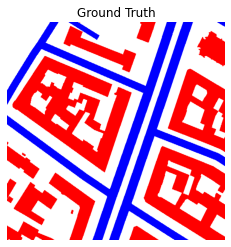

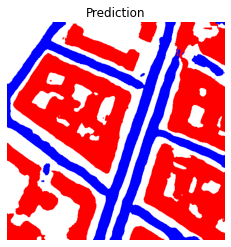

In [11]:
# Load Model Data
checkpoint = torch.load(TEST_PATH, map_location=device)
segmentation_model.load_state_dict(checkpoint['model_state_dict'])

# Ready for Testing
segmentation_model.eval()
img , gt = loader.__getitem__(0)
img = img.to(device)
gt = gt.squeeze().numpy()

# Get the class indicies 
out = nn.Softmax2d()(segmentation_model(img.unsqueeze(0)))
pred = np.argmax(out.squeeze(0).detach().cpu().numpy(), axis = 0)

# Perpare the image representation for prediction and ground truth
pred = pred[np.newaxis,:,:]
pred = np.concatenate((pred==0,pred==1,pred==2) , axis=0)

gt = gt[np.newaxis,:,:]
gt = np.concatenate((gt==0,gt==1,gt==2) , axis=0)

# Push channels to the last dim
gt = np.transpose(gt, (1,2,0)).astype(float)
pred = np.transpose(pred, (1,2,0)).astype(float)

# Covert the colors Green to White
gt[:,:,0] += gt[:,:,1]
gt[:,:,2] += gt[:,:,1]
pred[:,:,0] += pred[:,:,1]
pred[:,:,2] += pred[:,:,1]

# Plot GT
plt.imshow(gt)
plt.axis('off')
plt.title('Ground Truth')
plt.show()

# Plot Prediction
plt.imshow(pred)
plt.axis('off')
plt.title('Prediction')
plt.show()